# Demo of Generalized Fisherface

This notebook shows a quick demo of the Generalized Fisherface method via the implementation of the Generalized Fisher's Linear Discriminant in `generalized_fisher_ld.py`

Notes:
- in the implementation of standard fisherface, often (depending on $N$, $c$, and $n$) an initial PCA is necessary to avoid non-singular matrices for fisher's linear discriminant. For generalized Fisherface with $\alpha > 0$, this is no longer necessary.
- in standard fisherface, the number of components is limited to $c - 1$. In generalized fisherface, the limit is `n_samples` (confirm that this is true), same as eigenface! So, we benifit from the added components as well as from the separation between them. best of both worlds!
- it seems fisherface is suceptible to overfitting. in my intial tests, it would often get 100% train accuracy, but poor test accuracy.
- similar to eigenface, fisherface has visually-interpretable 'fisherfaces' which come out of the generalized eigenvector problem. Similarly, generalized fisherface also has visually-interpretable 'generalized-fisheraces' coming out of the generalized eigenvector problem.
- it seems: when `shrinkage != 'auto'`, standard fisherface requires an initial dimensionality reduction via PCA, but does not for $\alpha\neq0$.
- `shrinkage = 'auto'` seems to significantly improve performance (regardless of $\alpha, \beta$), figure out why...
- 'generalized discriminant analysis' is a term which currently exists, though it refers to a different kind of generalization than what exists here. In 2000, Baudat et al. proposed a kernel-approach for discriminant analysis which they called 'generalized discriminant analysis'. (I plan to apply this generalization to kernel-appraoches).

## Outline of Proposed Method

**Original Fisher's Linear Discriminant**
$$S_b w_i = \lambda_i S_w w_i$$

**Generalized Fisher's Linear Discriminant**
$$(S_t - (1-\beta)S_w) w_i = \lambda_i (\alpha S_w + (1 - \alpha I)) w_i$$

Note that $S_b = S_t - S_w$.

Hence, $\alpha = \beta = 0$ reduces to standard Fisher's linear discriminant, and $\alpha = \beta = 1$ reduces standard PCA.

## Set up

In [1]:
import numpy as np
import sklearn.pipeline
import matplotlib.pyplot as plt

In [2]:
# load data
import sklearn.datasets
from sklearn.model_selection import train_test_split


lfw_people = sklearn.datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target


print("Total dataset size:")
print("n_samples: ",  n_samples)
print("n_features: ", n_features)
print("n_classes: ", n_classes)



# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# first, scale the data
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_trfm = scaler.transform(X_train)
X_test_trfm = scaler.transform(X_test)

n_samples_train = len(X_train)

Total dataset size:
n_samples:  1288
n_features:  1850
n_classes:  7


In [3]:
def plot_faces(faces, n_cols=3, figsize=(8,6), h=h, w=w):

    dim, n_faces = faces.shape
    n_rows = n_faces // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(faces[:, i].reshape(h,w))

    return fig, ax

In [4]:
from generalized_fisher_ld import GeneralizedFisherLD

## Generalized Fisherface ($\alpha = \beta = 0$)

For $\alpha=\beta=0$, we reduce to standard fisherface. Recall that for standard fisherface, we first need to perform PCA to avoid singular matrices in the generalized eigenvector problem.

In [5]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components = n_samples_train - (n_classes - 1))),
                                           ('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0)),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = (fld_clf[1].transformation_matrix_ @ fld_clf[0].components_).T

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

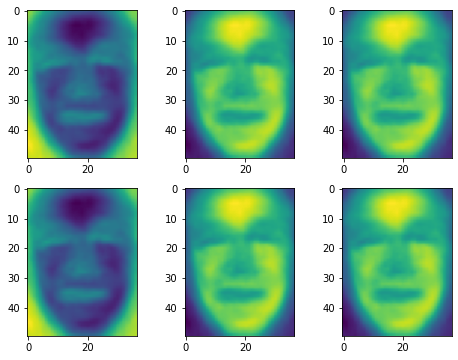

In [6]:
plot_faces(fisherfaces[:,:n_classes - 1])

In [7]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.4440993788819876


## Generalized Fisherface ($\alpha=\beta=1$)

For $\alpha = \beta = 1$ we reduce to standard PCA (and hence standard eigenface). Note that we don't need to initially perform PCA to avoid singular matrices for the generalized eigenvector calculation.

In [8]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=1, beta=1)),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = fld_clf[0].transformation_matrix_

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

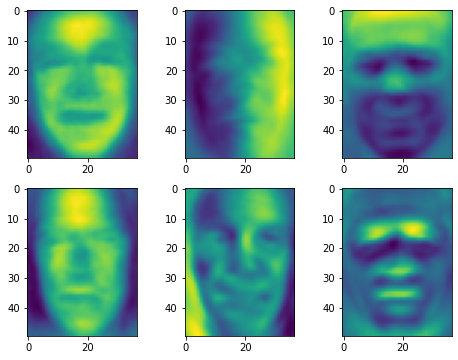

In [9]:
plot_faces(fisherfaces[:,:6])

In [10]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.484472049689441


In [11]:
# quickly compare against eigenface (very similar performance!)
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

eigenface = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=n_classes - 1)),
                                           ('rf', RandomForestClassifier())])
eigenface.fit(X_train_trfm, y_train)

print('train acc: ', eigenface.score(X_train_trfm, y_train))
print('test acc: ', eigenface.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.4937888198757764


## Generalized Fisherface ($\alpha=\beta=0.5$)

We now test intermediate values of $\alpha$ and $\beta$. Note that we still don't have to perform PCA first to avoid singular matrices!

In [12]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0.5, beta=0.5)),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = fld_clf[0].transformation_matrix_

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

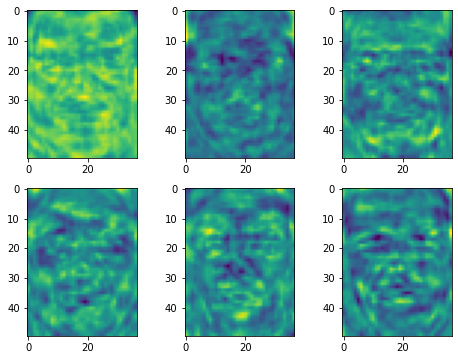

In [13]:
plot_faces(fisherfaces[:,:6])

In [14]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.8416149068322981


Note that $\alpha=0.5$ is significantly better than both $\alpha=\beta=1$ (standard eigenface) and $\alpha=\beta=0$ (standard fisherface)! This indicates that this generalization has value.

## More detailed evaluation

In [15]:
alpha_betas = np.linspace(0,1, num=51)

train_accs = []
test_accs = []

within_class_scatter = []
between_class_scatter = []
scatter_ratio = []

In [16]:
from tqdm import tqdm

# skip first because fisherface requires initial pca
for alpha_beta in tqdm(alpha_betas):
    alpha = beta = alpha_beta

    # if alpha=beta=0 (standard fisherface, need to do pca first)
    if alpha == beta == 0:
        fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components = n_samples_train - (n_classes - 1))),
                                           ('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0)),
                                           ('rf', RandomForestClassifier())])

        fld_clf.fit(X_train_trfm, y_train)

        within_class_scatter.append(fld_clf[1].within_class_scatter())
        between_class_scatter.append(fld_clf[1].between_class_scatter())
    else:
        fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=alpha, beta=beta)),
                                                    ('rf', RandomForestClassifier())])

        fld_clf.fit(X_train_trfm, y_train)

        within_class_scatter.append(fld_clf[0].within_class_scatter())
        between_class_scatter.append(fld_clf[0].between_class_scatter())


    train_accs.append(fld_clf.score(X_train_trfm, y_train))
    test_accs.append(fld_clf.score(X_test_trfm, y_test))



100%|██████████| 51/51 [03:59<00:00,  4.70s/it]


In [17]:
import pandas as pd
data_dict = {'alpha': alpha_betas, 'beta': alpha_betas, 'train_acc': train_accs, 'test_acc': test_accs,
             'within_scatter': within_class_scatter, 'between_scatter': between_class_scatter}

gfld_df = pd.DataFrame(data_dict)

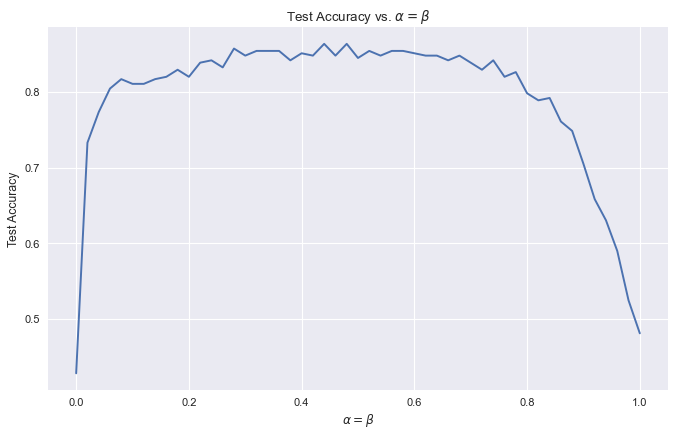

In [18]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,6), dpi=80);
ax.plot(alpha_betas, test_accs);
ax.set_title('Test Accuracy vs. $\\alpha = \\beta$');
ax.set_xlabel('$\\alpha=\\beta$');
ax.set_ylabel('Test Accuracy');

## Cross-Validation Grid Search over $\alpha$ and $\beta$

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1)),
                                           ('rf', RandomForestClassifier())])

# TODO: test with finer grid. (just takes longer)
param_grid = {
    "fld__alpha": np.linspace(0.1, 1, num=4), # excluding alpha=0 because that is a special case
    "fld__beta": np.linspace(0.1, 1, num=4),
}

cv_gridsearch = GridSearchCV(fld_clf, param_grid, n_jobs=-1, verbose=1)
cv_gridsearch.fit(X_train_trfm, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('fld',
                                        GeneralizedFisherLD(n_components=6)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'fld__alpha': array([0.1, 0.4, 0.7, 1. ]),
                         'fld__beta': array([0.1, 0.4, 0.7, 1. ])},
             verbose=1)

In [21]:
cv_gridsearch.best_params_

{'fld__alpha': 0.4, 'fld__beta': 0.4}

In [22]:
cv_gridsearch.best_score_

0.8405694140270284